# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

**Installing surprise library**

In [2]:
#!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross-validation
from surprise.model_selection import KFold

# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in the structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
df = pd.read_csv('ratings_Electronics.csv',names=['user_id', 'prod_id', 'rating', 'timestamp']) #Read in the data and define column names

In [5]:
df.head() #Look at the dataset

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
df.drop(['timestamp'],axis=1,inplace=True) #Drop timestamp column as it does not contain information relevant to recommendation

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [7]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [9]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [10]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [11]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [12]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Write your observations here**: The dataset has been reduced to 65290 rows and 3 columns

### **Data types**

In [13]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:** `user_id` and `prod_id` columns are both object types as they are a combination of numbers and charcters. Meanwhile `rating` column is float type as it is just a numerical scale ranging from 1 to 5.

### **Checking for missing values**

In [14]:
# Check for missing values present and provide observations
df_final.isnull().value_counts()

user_id  prod_id  rating
False    False    False     65290
Name: count, dtype: int64

**Write your observations here:** There are no missing values

### **Summary Statistics**

In [15]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here:** The ratings range from 1 to 5. The average rating is 4.29. Most customers generally products a full 5.

### **Checking the rating distribution**

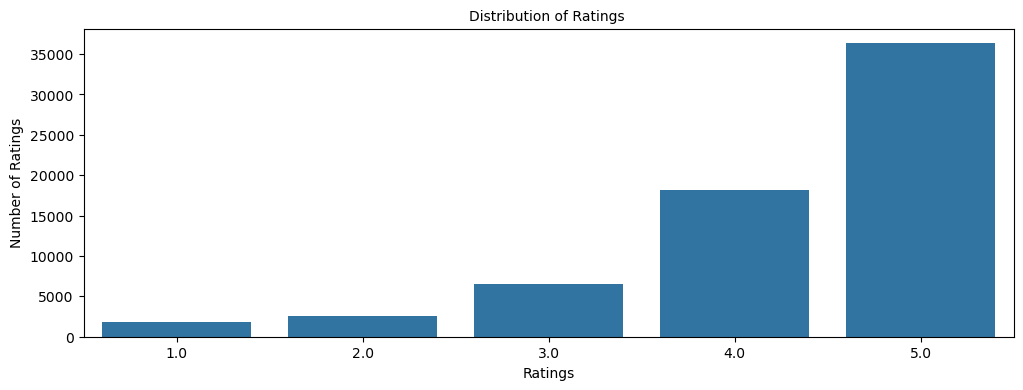

In [16]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 4))
sns.countplot(data=df_final,x='rating')
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Write your observations here:** 5 star ratings are the most prominent followed by 4 star ratings. Very few products are rated below 3 stars. This shows a high level of statisfaction with the products and services among the frequent customers.

### **Checking the number of unique users and items in the dataset**

In [17]:
# Number of total rows in the data and number of unique user id and product id in the data
print("Number of users:",df_final['user_id'].nunique())
print("Number of products:",df_final['prod_id'].nunique())

Number of users: 1540
Number of products: 5689


**Write your observations here:**  
- Number of users: 1540
- Number of products: 5689

### **Users with the most number of ratings**

In [18]:
# Top 10 users based on the number of ratings
df['user_id'].value_counts()[:10]

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: count, dtype: int64

**Write your observations here:**
Top 10 Users with most ratings:
1. A5JLAU2ARJ0BO
2. ADLVFFE4VBT8
3. A3OXHLG6DIBRW8
4. A6FIAB28IS79
5. A680RUE1FDO8B
6. A1ODOGXEYECQQ8
7. A36K2N527TXXJN
8. A2AY4YUOX2N1BQ
9. AWPODHOB4GFWL
10. ARBKYIVNYWK3C

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [19]:
# Calculate the average rating for each product
rating_avg = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
rating_count = df_final.groupby('prod_id').count()['rating']
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average_Rating':rating_avg, 'Rating_Count':rating_count})
# Sort the dataframe by average of ratings in the descending order
final_rating_ranked=final_rating.sort_values(by='Average_Rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating_ranked.head()

,Average_Rating,Rating_Count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [20]:
final_rating.describe() #Summary statistics of the product rankings dataframe

,Average_Rating,Rating_Count
count,5689.000000,5689.000000
mean,4.273844,11.476534
std,0.524442,11.410025
min,1.375000,5.000000
25%,4.000000,6.000000
50%,4.375000,8.000000
75%,4.666667,13.000000
max,5.000000,206.000000


In [21]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_recommendations(data, n, min_interactions = 20):
  # Finding products with minimum number of interactions
    recommendations = data[data['Rating_Count'] > min_interactions]
  # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='Average_Rating', ascending=False)
    return recommendations[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
#Identify the top 5 products with 50 interactions and print them
results = top_n_recommendations(final_rating,5,50)
for i in results.index:
  print(i)

B001TH7GUU
B003ES5ZUU
B0019EHU8G
B006W8U2MU
B000QUUFRW


The top 5 products with 50 interactions are products with the product ID:
1. B001TH7GUU
2. B003ES5ZUU
3. B0019EHU8G
4. B006W8U2MU
5. B000QUUFRW

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
#Identify the top 5 products with 100 interactions and print them
results = top_n_recommendations(final_rating,5,100)
for i in results.index:
  print(i)

B003ES5ZUU
B000N99BBC
B007WTAJTO
B002V88HFE
B004CLYEDC


The top 5 products with 100 interactions are products with the product ID:
1. B003ES5ZUU
2. B000N99BBC
3. B007WTAJTO
4. B002V88HFE
5. B004CLYEDC

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [24]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [25]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [26]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data_similarity = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data_similarity, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [27]:
# Declaring the similarity options
sim_opts = {
    'name': 'cosine',
    'user_based':True
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
UserSim_KNN = KNNBasic(sim_options=sim_opts,verbose=False, random_state=1)

# Fit the model on the training data
UserSim_KNN.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(UserSim_KNN)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Write your observations here:** Our initial User-Similarity model has an RMSE of 1.025 with excellent precision and good recall.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [28]:
# Predicting rating for a sample user with an interacted product
UserSim_KNN.predict('A3LDPF5FMB782Z','1400501466',r_ui=5,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Write your observations here:** Our User-Similarity recommendation system predicts that the user `userID=A3LDPF5FMB782Z` will give the product `productId=1400501466` a rating of 3 when in reality they gave it a rating of 5. The model misses by two ratings lower which is not good. This model would fail to recommend products that the customer in fact would like very much thus missing out on potential revenue.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [29]:
# Find unique user_id where prod_id is not equal to "1400501466"
df.loc[~(df['prod_id']=='1400501466')]['user_id'].unique()
#df.loc[~(df['prod_id']=='1400501466') & (df['user_id'] == 'A34BZM6S9L7QI4')]['user_id'].unique()

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [30]:
# Predicting rating for a sample user with a non interacted product
UserSim_KNN.predict('A34BZM6S9L7QI4','1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:** As before, the recommendation system predicts a rating of 3 for the product `productId=1400501466` from the user `userId=A34BZM6S9L7QI4`. It seems like the model is biased towards the more average rating of around 3 for most products. The model clearly needs to have its hyper parameters tuned.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [31]:
# Setting up parameter grid to tune the hyperparameters
params_grid = {
    'k' : [10, 20, 30, 40],
    'min_k' : [3, 5, 7, 9],
    'sim_options' : {
        'name':['cosine','msd'],
        'user_based':[True]
    }
}
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, params_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
# Fitting the data
gs.fit(data_similarity)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9699144452164049
{'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [32]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_opts_tuned = {
    'k': 40,
    'min_k': 5,
    'name': 'cosine',
    'user_based': True
}
# Creating an instance of KNNBasic with optimal hyperparameter values
UserSim_KNN_tuned = KNNBasic(sim_options=sim_opts_tuned,verbose=False, random_state=1)
# Training the algorithm on the trainset
UserSim_KNN_tuned.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(UserSim_KNN_tuned)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Write your observations here:** There is no discernable improvement to the model from hyperparameter tuning. The RMSE is still 1.025 and the precision and recall maintain the same values as well.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [33]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
UserSim_KNN_tuned.predict('A3LDPF5FMB782Z','1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.0, details={'actual_k': 4, 'was_impossible': False})

In [34]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
UserSim_KNN_tuned.predict('A34BZM6S9L7QI4','1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:** Once again, the tuned model gives the same results as the baseline model. It predicts that both the user `userId="A3LDPF5FMB782Z"` who bought and rated the product 5 will rate it as 3 and the user `userId="A34BZM6S9L7QI4"` who has not bought it will also rate it 3. Perhaps a different model needs to be used.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [35]:
# 0 is the inner id of the above user
UserSim_KNN_tuned.get_neighbors(0, k=5)

[7, 12, 16, 17, 26]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [36]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [37]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommend_results = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, UserSim_KNN_tuned)
recommend_results

[('B00001W0DI', 5),
 ('B00002EQCW', 5),
 ('B00003006R', 5),
 ('B00004W3ZQ', 5),
 ('B00004WCFT', 5)]

The top 5 products that user `userID=A3LDPF5FMB782Z` would be interested in are:
1. B00001W0DI
2. B00002EQCW
3. B00003006R
4. B00004W3ZQ
5. B00004WCFT

In [38]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommend_results, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00001W0DI,5
1,B00002EQCW,5
2,B00003006R,5
3,B00004W3ZQ,5
4,B00004WCFT,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [39]:
# Declaring the similarity options
sim_opts = {
    'name': 'cosine',
    'user_based':False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
ItemSim_KNN = KNNBasic(sim_options=sim_opts,verbose=False, random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
ItemSim_KNN.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(ItemSim_KNN)

RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**Write your observations here:** The Item-Similarity recommendation system has a lower RMSE than User-Similarity system at 1.0232. It does have a slightly lower precision and recall than the User-Similarity model however.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [40]:
# Predicting rating for a sample user with an interacted product
ItemSim_KNN.predict('A3LDPF5FMB782Z','1400501466',r_ui = 5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

**Write your observations here:** The Item-Similarity system does a better job at predicting the ratings of the user than the User-Similarity system. It predicts that user `userID=A3LDPF5FMB782Z` will rate the product `prodID=1400501466` as 4.31 which is quite close to the real rating of 5.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [41]:
# Predicting rating for a sample user with a non interacted product
ItemSim_KNN.predict('A34BZM6S9L7QI4','1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:** The recommendation system predicts a rating of 4.29 for the product `productId=1400501466` from the user `userId=A34BZM6S9L7QI4`.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [42]:
# Setting up parameter grid to tune the hyperparameters
params_grid = {
    'k' : [10, 20, 30],
    'min_k' : [3, 6, 9],
    'sim_options' : {
        'name':['cosine', 'msd'],
        'user_based':[False]
    }
}
# Performing 3-fold cross validation to tune the hyperparameters
gs_Item = GridSearchCV(KNNBasic, params_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting the data
gs_Item.fit(data_similarity)
# Find the best RMSE score
print(gs_Item.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs_Item.best_params['rmse'])

0.9753340403762659
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [43]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_opts_tuned = {
    'k': 30,
    'min_k': 6,
    'name': 'msd',
    'user_based': False
}
# Creating an instance of KNNBasic with optimal hyperparameter values
ItemSim_KNN_tuned = KNNBasic(sim_options=sim_opts_tuned,verbose=False, random_state=1)
# Training the algorithm on the trainset
ItemSim_KNN_tuned.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(ItemSim_KNN_tuned)

RMSE: 1.0264
Precision:  0.836
Recall:  0.757
F_1 score:  0.795


**Write your observations here:** There is not a significant change in the model performance. The hyperparameter tuning results in a slight drop in RMSE and in exchange gives a slight improvement in precision and recall but it is negligibly small.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [44]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
ItemSim_KNN_tuned.predict('A3LDPF5FMB782Z','1400501466',r_ui = 5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.699444206926037, details={'actual_k': 19, 'was_impossible': False})

In [45]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
ItemSim_KNN_tuned.predict('A34BZM6S9L7QI4','1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:** The predictions from the tuned Item-Similarity system are much better. The system predicts that user `userID=A3LDPF5FMB782Z` will rate the product a 4.69 which is much closer to the actual value of 5 as compared to the baseline model. Similarly for user `userID=A34BZM6S9L7QI4` who has not seen the product, it predicts a rating of 4.29.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [46]:
ItemSim_KNN_tuned.get_neighbors(0, k=5)

[53, 67, 106, 151, 156]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [47]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommend_results_item = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, UserSim_KNN_tuned)
recommend_results_item

[('B00001W0DI', 5),
 ('B00002EQCW', 5),
 ('B00003006R', 5),
 ('B00004W3ZQ', 5),
 ('B00004WCFT', 5)]

In [48]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommend_results_item, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00001W0DI,5
1,B00002EQCW,5
2,B00003006R,5
3,B00004W3ZQ,5
4,B00004WCFT,5


The top 5 products that user `userID=A3LDPF5FMB782Z` would be interested in are:
1. B00001W0DI
2. B00002EQCW
3. B00003006R
4. B00004W3ZQ
5. B00004WCFT

These results are the same as what we got out of the User-Similarity system showing that the systems are consistent in their predictions.

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [49]:
# Using SVD matrix factorization. Use random_state = 1
rec_svd = SVD(random_state=1)
# Training the algorithm on the trainset
rec_svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(rec_svd)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**Write your observations here:** SVD recommendation system has given the best RMSE at 0.89 with excellent precision and recall. Matrix factorization has been the best performing model out of all the models used.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [50]:
# Making prediction
rec_svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.070652912318144, details={'was_impossible': False})

**Write your observations here:** SVD predicts that user `userID=A3LDPF5FMB782Z` will rate the product `prodID=1400501466` as 4 which is quite close to the real rating of 5. This is not as close as Item-Similarity but it still gets sufficiently close.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [51]:
# Making prediction
rec_svd.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.3949263041205775, details={'was_impossible': False})

**Write your observations here:** SVD predicts that user `userID=A34BZM6S9L7QI4` will rate the product `prodID=1400501466` as 4.39 which is consistent with the results from the previous models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [52]:
# Set the parameter space to tune
params_grid = {
    'n_epochs': [10, 20, 30], 
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}
# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, params_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
gs_svd.fit(data_similarity)
# Best RMSE score
print(gs_svd.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

0.8986733745657562
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
rec_svd_tuned = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)
# Train the algorithm on the trainset
rec_svd_tuned=rec_svd_tuned.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(rec_svd_tuned)

RMSE: 0.8899
Precision:  0.862
Recall:  0.796
F_1 score:  0.828


**Write your observations here:** SVD system also shows insignificant improvement with hyperparameter tuning like Item-Similarity. The RMSE score improved by 0.01 to 0.88 while precision and recall show no improvement.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [54]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
rec_svd_tuned.predict('A3LDPF5FMB782Z','1400501466',r_ui=5)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1155455665170155, details={'was_impossible': False})

In [55]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
rec_svd_tuned.predict('A34BZM6S9L7QI4','1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.163970514424571, details={'was_impossible': False})

The predictions from the tuned SVD system are much better than the baseline system. The system predicts that user `userID=A3LDPF5FMB782Z` will rate the product a 4.11 which is much closer to the actual value of 5 as compared to the baseline. Similarly for user `userID=A34BZM6S9L7QI4` who has not seen the product, it predicts a rating of 4.19.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

### Conclusions
- Four models of recommendation systems were built: Populatrity based recommendation system, User-Similarity recommendation system, Item-Similarity recommendation system and SVD recommendation system.
- Popularity based system was used to rank the most popular products through out the whole user base on the site. This system ranked the products independant of the user behaviour or product interactions. Hence, this system is not very useful in giving personalized recommendations.
- User-Similarity system was used to suggest recommendations based on similarity between users in the dataset. The model had the worst performance with the highest RMSE of 1.025 with an F-score of 0.82. The system was seen to have very poor precision in predicting the ratings given by users as seen when the system predicted a rating of 3 for a product that was actually rated 5. Even hyperparameter tuning could not improve the performance of the recommendation system. So, User-Similarity recommendation system might not be the best system.
- Item-Similarity system was used suggest recommendations based on similarity between products in the dataset. This model had a much better performance with better RMSE at 1.023 but a slightly lower F-score of 0.79. This model was the best performing in predicting the ratings that a user would give a product being able estimate very close to the actual ratings given by users to the items. Hyperparameter tuning provides only minimal improvements to system performance.
- Finally, SVD recommendation system was built to recommend based on both users and item interactions. This model had the best performance with a low RMSE of 0.89 and an F-Score of 0.82. The performance of this model was great being able to closely predict the ratings a user would give to a product. Though, it was slightly less accurate than Item-Similarity system. Hyperparameter tuning once again did not result in any improvements in the system performance.

### Recommendations
- Multiple recommendation systems should be used in conjunction to give the best recommendations to the users.
- The popularity based recommendation can be used to give a set of general "trending products" recommendations to all users irrespective of their purchase history or interests preferably on the home page. While this may not get a lot users to buy products, it could get users to expand the diversity of products they use and even be recommended products that they would like but are not being recommended as it does not follow their usual purchase habits. This is also a good way to provide a starting point for new customers to buy products and allow Amazon to start building an user profile to start personalizing recommendations.
- For personalized recommendations, a mix of Item-Similarity recommendations and SVD-recommendations system should be used.
- Item-Similarity recommendation system is suggested to be used to provide very close recommendations to products the user is currently browsing or have recently purchased. These recommendations can be given with the guarantee that the user will be interested in them as they are currently engaged in browsing or purchasing a similar product. Users are probably looking for a few different products of similar nature to compare before buying and using Item-Similarity system would help improve this experience for the user.
- SVD recommendation system should be used to provide a diverse range of recommendations based on the users purchase history and browsing habits on both the home page as well as when browsing the marketplace. The system should be used to give recommendations that are not just similar to products the user has liked, but also products that could be adjacent and complimentary to the products bought or being browsed. This could encourage users to branch out from their niche and buy more products.
- Finally, User-Similarity recommendation system is not advisable to use based purely on user-item interactions. The system should be complimented with user information such as personal details, geographic data, browsing habits etc.